## Unterteilung des Zustands Zuhause in Zwischenstopp und Endaufenthalt

In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# einlesen des bearbeiteten Trips-Datensatz
df = pd.read_csv(r"C:\Users\thoma\Desktop\ev-modelling-repo\Rohdaten\NHTS_trips_processed_WT_Aufenthalt.csv")

In [3]:
df.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
0,300000071,1,3,1,1,4,8.439,15,1000,1015,600,615,40,295
1,300000071,1,3,2,4,1,8.286,20,1510,1530,910,930,61,1110
2,300000073,1,3,1,1,2,3.621,15,845,900,525,540,35,330
3,300000073,1,3,2,2,1,3.610,15,1430,1445,870,885,58,1080
4,300000081,4,6,1,1,2,12.902,15,1115,1130,675,690,45,720


In [4]:
filt = df["Whyto"] == 1
df_filt = df[filt]

In [5]:
df_filt.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
1,300000071,1,3,2,4,1,8.286,20,1510,1530,910,930,61,1110
3,300000073,1,3,2,2,1,3.610,15,1430,1445,870,885,58,1080
5,300000081,4,6,2,2,1,12.902,10,2330,2340,1410,1420,94,695
7,300000121,4,4,2,4,1,5.464,15,700,715,420,435,28,15
9,300000121,4,4,4,4,1,1.632,10,805,815,485,495,32,45


In [6]:
type(filt)

pandas.core.series.Series

In [7]:
df_filt.index

Int64Index([     1,      3,      5,      7,      9,     12,     14,     16,
                18,     21,
            ...
            596253, 596255, 596257, 596262, 596266, 596268, 596270, 596273,
            596277, 596279],
           dtype='int64', length=200794)

In [8]:
index_stopover = []
index_final = []

In [9]:
# Indizes der Home-Trips aufteilen in Endstopps und Zwischenstopps
for i in df_filt.index:
    if (i+1 not in df.index) or (df.at[i+1, "ID"] != df.at[i, "ID"]):
        index_final.append(i)
    else:
        index_stopover.append(i)

In [10]:
len(index_final)

140000

In [11]:
len(index_stopover)

60794

In [12]:
df_final = df.iloc[index_final]

In [13]:
df_final.shape

(140000, 14)

In [14]:
df_stopover = df.iloc[index_stopover]

In [15]:
aufenthalt_final = df_final["Stay_duration"]

In [16]:
aufenthalt_stopover = df_stopover["Stay_duration"]

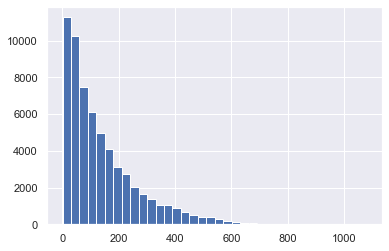

In [17]:
sns.set();
plt.hist(aufenthalt_stopover, bins=range(int(min(aufenthalt_stopover)), int(max(aufenthalt_stopover)), 30));

In [18]:
x = np.linspace(0, max(aufenthalt_stopover), 1000)
shape_stopover, loc_stopover, scale_stopover = stats.lognorm.fit(aufenthalt_stopover, loc=0)
pdf_stopover = stats.lognorm.pdf(x, s=shape_stopover, loc=loc_stopover, scale=scale_stopover)

(-100, 1200)

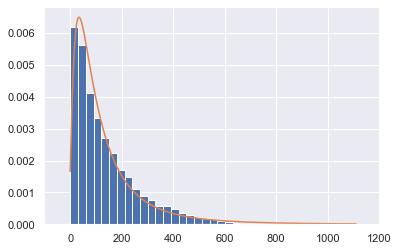

In [19]:
plt.figure()
plt.hist(aufenthalt_stopover, bins=range(int(min(aufenthalt_stopover)), int(max(aufenthalt_stopover)), 30), density=True);
plt.plot(x, pdf_stopover)
plt.gca().set_xlim(-100, 1200)

In [20]:
test = []
for i in range(100000):
    number = stats.lognorm.rvs(s=shape_stopover, loc=loc_stopover, scale=scale_stopover)
    if number < 0:
        test.append(number)

In [21]:
len(test)/100000

0.00531

### etwa 0,4 % der Werte negativ -> in Simulation berücksichtigen

## Parameter der Verteilungsfunktion abspeichern

In [22]:
import pickle
import os 

path = os.getcwd()+ "\\Simulationsdaten"
if not os.path.exists(path):
    os.makedirs(path)

shape_loc_scale = [shape_stopover, loc_stopover, scale_stopover]
pickle.dump(shape_loc_scale, open(path+"\\Zuhause_Shape_Loc_Scale_Stopover.pickle", "wb"))

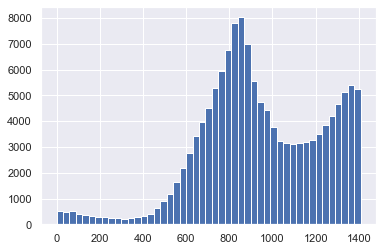

In [23]:
plt.hist(aufenthalt_final, bins=range(int(min(aufenthalt_final)), int(max(aufenthalt_final)), 30));

In [24]:
trips_t_final = [0 for i in range(97)]
trips_t_stopover = [0 for i in range(97)]

In [25]:
for i in df_final.index:
    t = df_final.at[i,"Departure_t"]
    trips_t_final[t] += 1

In [26]:
for i in df_stopover.index:
    t = df_stopover.at[i,"Departure_t"]
    trips_t_stopover[t] += 1

In [27]:
for t in range(97):
    total = trips_t_final[t] + trips_t_stopover[t]
    trips_t_final[t] = trips_t_final[t] / total
    trips_t_stopover[t] = trips_t_stopover[t] / total

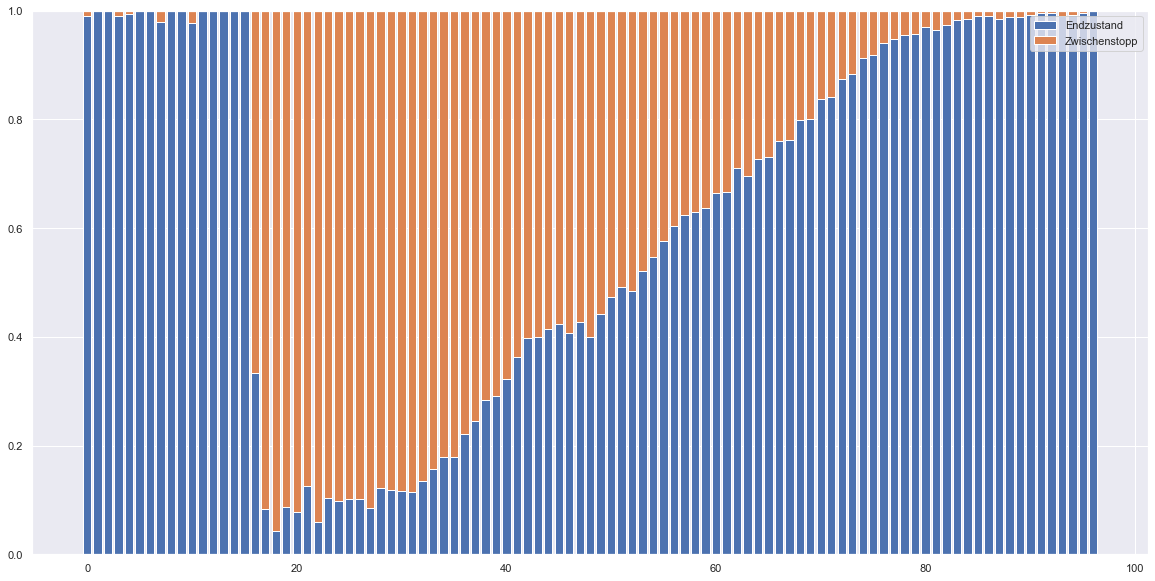

In [28]:
plt.figure(figsize=(20,10))
x = np.linspace(0, 96, 97)
plt.bar(x, trips_t_final, label="Endzustand")
plt.bar(x, trips_t_stopover, bottom= trips_t_final, label="Zwischenstopp")
plt.legend();

In [29]:
pickle.dump(trips_t_final, open(path+"\\Zuhause_Wahrscheinlichkeit_Endzustand.pickle","wb"))

In [30]:
trips_t_final

[0.9910714285714286,
 1.0,
 1.0,
 0.9894736842105263,
 0.9935064935064936,
 1.0,
 1.0,
 0.9787234042553191,
 1.0,
 1.0,
 0.9772727272727273,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.3333333333333333,
 0.08333333333333333,
 0.043478260869565216,
 0.08695652173913043,
 0.0784313725490196,
 0.125,
 0.058823529411764705,
 0.102803738317757,
 0.09881422924901186,
 0.10212765957446808,
 0.10174418604651163,
 0.08564231738035265,
 0.12227805695142378,
 0.11857142857142858,
 0.11615628299894404,
 0.1137218045112782,
 0.1354679802955665,
 0.1560418648905804,
 0.17899543378995433,
 0.17916666666666667,
 0.22118380062305296,
 0.24458700882117082,
 0.28321678321678323,
 0.29178885630498536,
 0.3227199136535348,
 0.362691466083151,
 0.3981164383561644,
 0.39979808177688037,
 0.4146253602305475,
 0.4228961982058949,
 0.406427854034148,
 0.4271199687377882,
 0.3994609164420485,
 0.4426403106247794,
 0.47245564892623715,
 0.49155405405405406,
 0.48493589743589743,
 0.5204702067288204,
 0.5463167878596269,
 0.